# Invoice Classification From Scanned Documents

In modern financial operations, a large number of documents are being processed every day. How a document can and should processed depends on the type of document, therefore identifying the document type is a important baseline step in document processing. Automating the task of identifying the type of document will be the goal of this project, as having a algorithm that perform such a task can reduce manual, repetitive labour and improve the processing time of these documents.

In this project, I will tackle this task using Convolutional Neural Networks (CNNs) with pytorch and train them on gray-scaled images of the documents. The goal of these CNNs is to learn the structural layout and pattern that each document type has and use to that knowledge to distinguish between the different document types. The dataset that will be used to train this CNNs is the [RVL-CDIP dataset](https://huggingface.co/datasets/aharley/rvl_cdip), which consists of 400.000 grayscale images of documents that do not exceed 1000 pixels. There exists 16 different classes in the entire dataset with 25.000 images for each class. Many of the classes within this dataset will not fit any use case within a business or finance setting, therefore these classes will be relabeled as negative sample, i.e samples that the model should not assign any classes. Due to the large number of samples not being relevant in a finance setting and therefore the model needs to give these samples a low confidence for all classes, Entropic Open-set Loss(Softmax adaptation) will be used to reject unknown samples. The dataset is split into 320.000 training images, 40.000 validation images, and 40.000 test images. 

The main goal of this project is to create model that can take a image input and accurately classify its document type, here the goal accuracy is 90% or higher. Our Secondary goals would be for the model to be light in size and quick with its output.

References: A. W. Harley, A. Ufkes, K. G. Derpanis, "Evaluation of Deep Convolutional Nets for Document Image Classification and Retrieval," in ICDAR, 2015; [study link](https://adamharley.com/icdar15/)

## Loading Dataset

In [1]:
from datasets import load_dataset

# Beware: Dataset is about 38 GB large
ds = load_dataset("aharley/rvl_cdip", trust_remote_code=True)

Loading dataset shards:   0%|          | 0/77 [00:00<?, ?it/s]

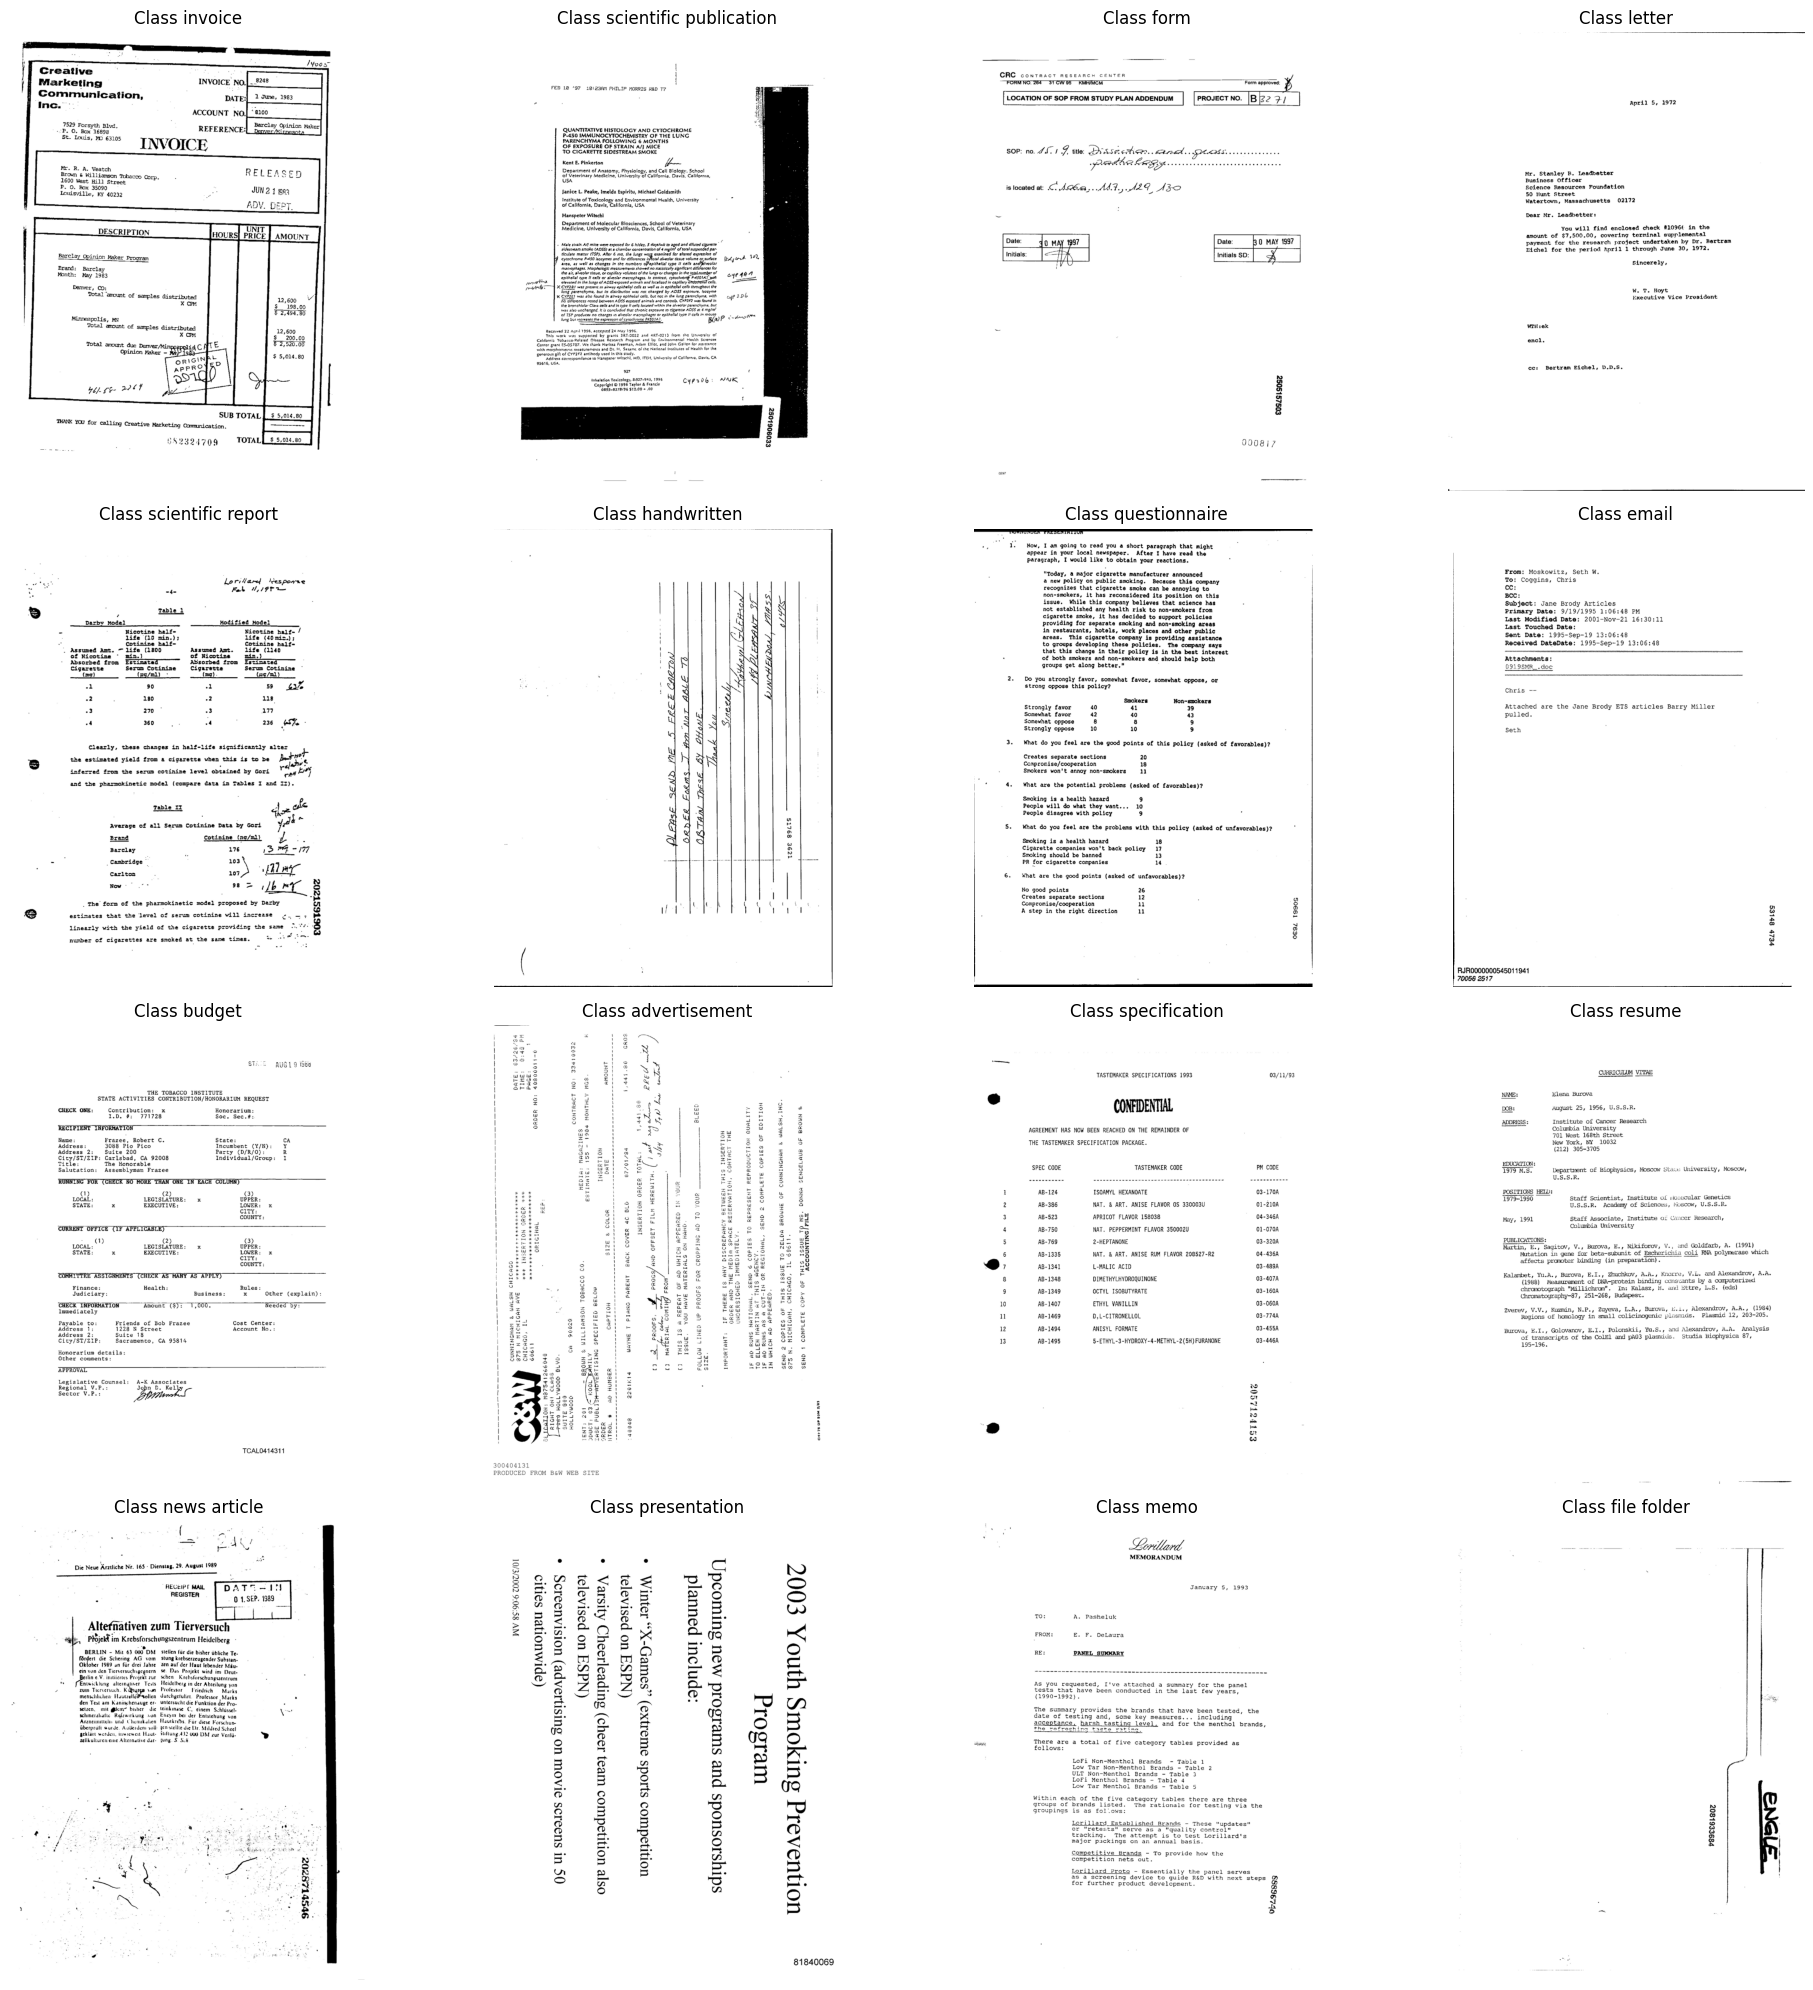

In [2]:
import numpy as np
from matplotlib import pyplot

fig, axes = pyplot.subplots(4, 4, figsize=(20, 20))  

classes = ds['train'].features['label'].names

seen = set()
i = 0
row = 0
col = 0
for sample in ds['train']:
    label = sample['label']
    if label not in seen:
        axes[row][col].imshow(sample['image'], cmap='gray')
        axes[row][col].set_title(f"Class {classes[label]}")
        axes[row][col].axis('off')
        seen.add(label)
        if row == 3:
            col += 1
            row = 0
        else:
            row += 1

    if len(seen) == 16:
        break

pyplot.tight_layout()
pyplot.show()

### Assigning negative label to samples unrelated to business and finances

In [3]:
from datasets import concatenate_datasets, ClassLabel

finance_labels = [
    "form",
    "email",
    "advertisement",
    "specification",
    "file folder",
    "budget",
    "invoice",
    "presentation",
    "resume",
    "memo"
]

finance_labels = [classes.index(i) for i in finance_labels]

finance_classes = [classes[i] for i in finance_labels]

all_labels = list(range(len(classes)))

updated_classes = finance_classes + ['unknown']

updated_labels =  ClassLabel(names = updated_classes)

new_label_mapping = {old_label: new_label for new_label, old_label in enumerate([classes.index(i) for i in finance_classes])}
new_label_mapping['unknown'] = len(finance_classes)

def map_label(x):
    if x['label'] in new_label_mapping:
        return {'label': new_label_mapping[x['label']]}
    return {'label': new_label_mapping['unknown']}

complete_ds = ds.map(map_label)

complete_ds = complete_ds.cast_column("label", updated_labels)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/40000 [00:00<?, ? examples/s]

## Explorative Data Analysis

### Class Distribution
Since all the labels that are not related to finances have been removed and all of the samples of these labels have been given the garbage class "unknown", the new class distribution needs to be examined to see how balanced the dataset is in its current state. 


Number of unique classes: 11
[ 25000  25000  25000  25000  25000  25000  25000  25000  25000  25000
 150000]


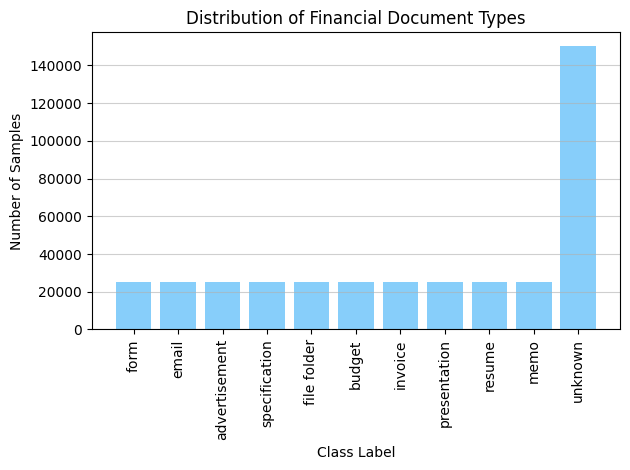

In [4]:
import numpy
from matplotlib import pyplot
import pandas


EDA_Dataset = concatenate_datasets([complete_ds['train'],complete_ds['validation'],complete_ds['test']])
labels = EDA_Dataset['label']
print()
unique_labels, counts = numpy.unique(labels, return_counts=True)


print(f"Number of unique classes: {len(unique_labels)}")
print(counts)

pyplot.bar(EDA_Dataset.features['label'].names, counts, width=0.8,color='#87CEFA')
pyplot.xlabel('Class Label')
pyplot.ylabel('Number of Samples')
pyplot.title('Distribution of Financial Document Types')
pyplot.xticks(unique_labels,rotation=90) 
pyplot.grid(axis='y', linestyle='-', alpha=0.6)
pyplot.tight_layout()
pyplot.show()

## Preprocessing

### Image Preprocessing

In [ ]:
import torch
from torchvision import transforms
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os

if torch.cuda.is_available():
    print("Successfully enabled CUDA processing")
    dev = torch.device("cuda")
else:
    print("CUDA processing not available, will use CPU instead.")
    dev = torch.device("cpu")

complete_ds.set_format('torch', device = dev)
print(len(complete_ds))
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Successfully enabled CUDA processing
3


### Create Custom Dataset Object 

In [6]:
class ScannedDocumentDataset(Dataset):
    def __init__(self, dataset, type="train",transform=None):
        self.dataset = dataset[type]
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['label']

        if self.transform:
            image = self.transform(image)

        return image, label

### Initialize Dataloaders

In [7]:
train_ds = ScannedDocumentDataset(dataset=complete_ds, type="train", transform=image_transforms)
val_ds = ScannedDocumentDataset(dataset=complete_ds, type="validation", transform=image_transforms)
test_ds = ScannedDocumentDataset(dataset=complete_ds, type="test", transform=image_transforms)

batch_size = 64 

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds,batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=batch_size,shuffle=False)